# Runthrough

### Introduction

We want to know whether men spend more than women on Black Friday at Walmart...

Let's start by loading and viewing the dataset:

In [196]:
# Import appropriate libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 20})

# Load the data as a dataframe from the csv file
df = pd.read_csv('./walmart_data.csv')

# Make all column names lowercase for sanity
df.columns = [c.lower() for c in df.columns]

# Display the first 5 rows of data to get an idea of what we're working with
df.head()

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category,purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


We can do some initial exploration to learn about the spending of men and women

First let's look at what the total purchase amounts and products bought were for men and women:

In [197]:
print('\nSum total of purchase (dollar) amounts: ')
print(df.groupby(['gender'])['purchase'].sum())

print('\nTotal number of different products purchased: ')
print(df.groupby(['gender'])['product_id'].nunique())

print('\nTotal number of transactions: ')
print(df.groupby(['gender'])['purchase'].count())

print('\nNumber of men and women in the data: ')
print(df.groupby(['gender'])['user_id'].nunique())


Sum total of purchase (dollar) amounts: 
gender
F    1186232642
M    3909580100
Name: purchase, dtype: int64

Total number of different products purchased: 
gender
F    3367
M    3588
Name: product_id, dtype: int64

Total number of transactions: 
gender
F    135809
M    414259
Name: purchase, dtype: int64

Number of men and women in the data: 
gender
F    1666
M    4225
Name: user_id, dtype: int64


As we can see, men clearly spent more money, bought a larger number of different products, and had more separate transactions than women

There are over two and a half times as many men as there are women, so it makes sense that they are accounting for so many more purchases

We want to normalize these results to control for the population difference between men and women

We have two options to divide by:
- The number of individual transactions for each gender

    - This will give us an idea of what each gender is contributing to the total purchase amount, what each transaction is likely to do based on gender


- The number of unique users for each gender

    - This will give us an idea of the average spending patterns per user, what each individual is likely to do based on gender
    
We will be using these metrics for many future normalizations, so let's define them now and then normalize our previous numbers:

In [198]:
num_transactions = df.groupby(['gender'])['purchase'].count()

num_users = df.groupby(['gender'])['user_id'].nunique()

In [199]:
print('\nNormalized (per transaction) sum total of purchase (dollar) amounts: ')
print(df.groupby('gender')['purchase'].sum() / num_transactions)

print('\nNormalized (per transaction) total number of different products purchased: ')
print(df.groupby('gender')['product_id'].nunique() / num_transactions)


Normalized (per transaction) sum total of purchase (dollar) amounts: 
gender
F    8734.565765
M    9437.526040
Name: purchase, dtype: float64

Normalized (per transaction) total number of different products purchased: 
gender
F    0.024792
M    0.008661
dtype: float64


This tells us that the average male transaction is about 8% more than the female

but the average male transaction has about 1/3 the number of different products compared to the female

So the male transactions are in fewer product categories and are more expensive

In [200]:
print('\nNormalized (per user) sum total of purchase (dollar) amounts: ')
print(df.groupby('gender')['purchase'].sum() / num_users)

print('\nNormalized (per user) total number of different products purchased: ')
print(df.groupby('gender')['product_id'].nunique() / num_users)

print('\nNormalized (per user) total number of transactions: ')
print(df.groupby('gender')['purchase'].count() / num_users)


Normalized (per user) sum total of purchase (dollar) amounts: 
gender
F    712024.394958
M    925344.402367
dtype: float64

Normalized (per user) total number of different products purchased: 
gender
F    2.021008
M    0.849231
dtype: float64

Normalized (per user) total number of transactions: 
gender
F    81.518007
M    98.049467
dtype: float64


This tells us that the average male shopper spends about 30% more than the average female shopper

but they only buy less than half the number of different products as the average female shopper

and they have about 20% more transactions than the average female shopper

So similar to above, the males seem to spend more, have more transactions, but only buy specific products

Is this enough to say that even after controlling for their population differences, men spend more than women?

Let's look further into how many products they are buying (how many transactions they have in this case)

<AxesSubplot:>

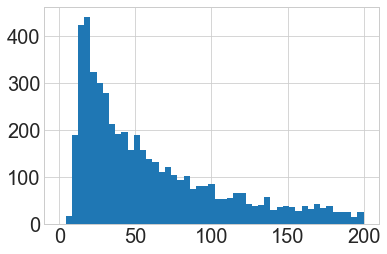

In [201]:
# Look at the number of products bought by users
# Group the data by the user_id and count the number of product_ids each of them have
# Basically this tells us how many transactions individuals have and groups them into bins
df.groupby(['user_id'])['product_id'].count().hist(bins=np.linspace(0, 200, 50))

Here we see that most users buy around 20 products with no visible outliers

Let's split this into male and female shoppers

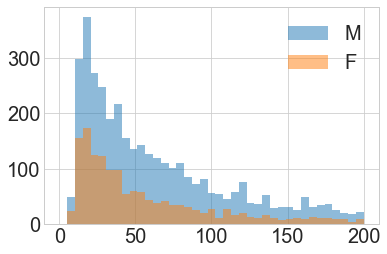

In [202]:
# Next we want to compare these purchase amounts between men and women
# Group the data by user_id and gender and add their respective product_id counts
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        d['M'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='M'),
        d['F'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='F')
    )
)
plt.legend()

Here we can see that the distributions seem comparable between men and women with the men accounting for many more sales

Let's check the what it looks like when normalized by transaction and user

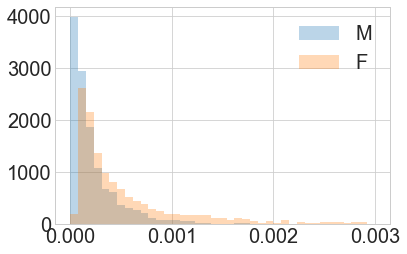

In [203]:
# Divide by the number of transactions per gender to see overall contributions
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        (d['M'] / d['M'].sum()).dropna().hist(bins=np.linspace(0, 0.003, 40), alpha=0.3, label='M', density=True),
        (d['F'] / d['F'].sum()).dropna().hist(bins=np.linspace(0, 0.003, 40), alpha=0.3, label='F', density=True)
    )
)
plt.legend()

Here is looks like many more men have a very small number of purchases but more women consistently have more purchases than men, so they might even out 

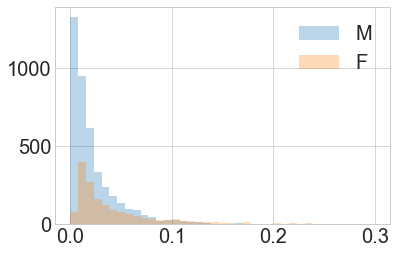

In [267]:
# Divide by the number of users per gender to see individual stats
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        (d['M'] / len(d['M'].dropna())).dropna().hist(bins=np.linspace(0, 0.3, 40), alpha=0.3, label='M'),
        (d['F'] / len(d['F'].dropna())).dropna().hist(bins=np.linspace(0, 0.3, 40), alpha=0.3, label='F')
    )
)
plt.legend()

A similar result can be seen here

- Sidenote: need to find out what exactly density=True does and do we even need to divide to normalize or can we just use that? Because something very interesting happens when it's used on the original unnormalized graph:

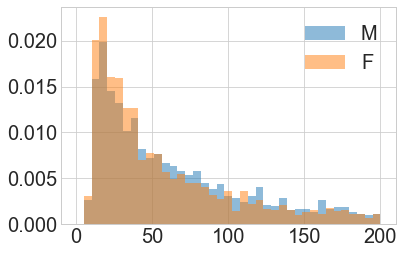

In [205]:
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        d['M'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='M', density=True),
        d['F'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='F', density=True)
    )
)
plt.legend()

Let's generate some heat maps to understand which products men and women are more likely to buy

First raw numbers:

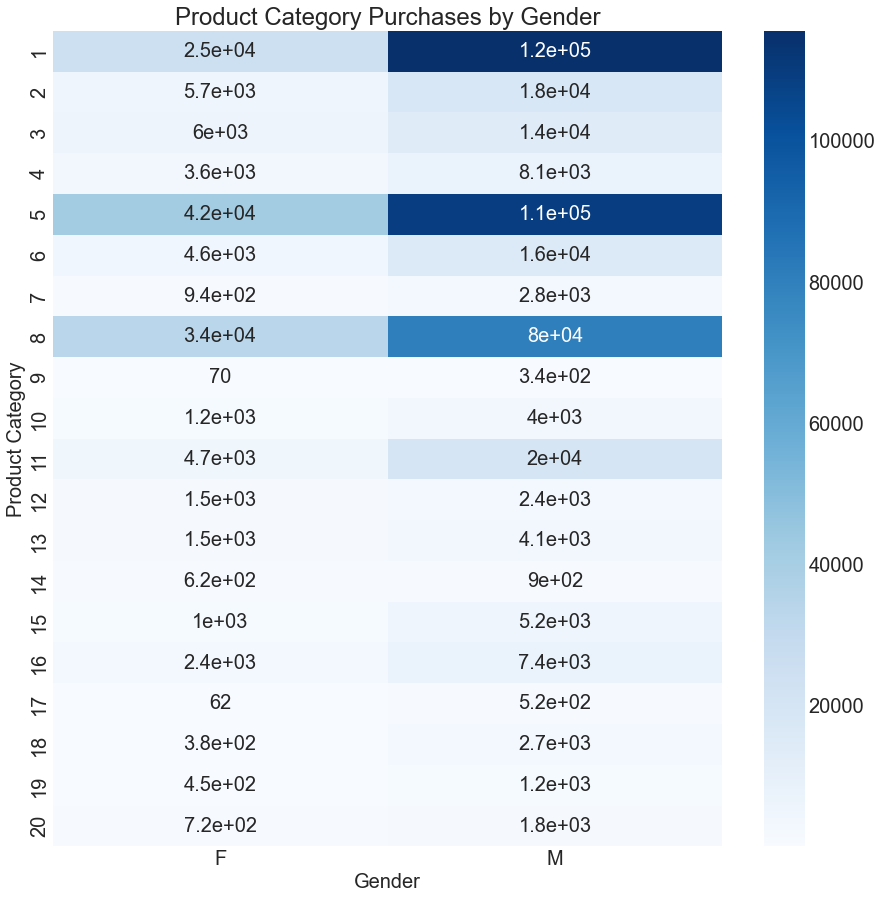

In [260]:
category_gender_counts = df.groupby(['product_category', 'gender'])['purchase'].count().unstack().fillna(0)

# Plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(category_gender_counts, annot=True, cbar=True, cmap="Blues")

# Add labels and title
plt.title("Product Category Purchases by Gender")
plt.xlabel("Gender")
plt.ylabel("Product Category")
plt.show()

Now normalized:

In [261]:
print(num_users)

gender
F    1666
M    4225
Name: user_id, dtype: int64


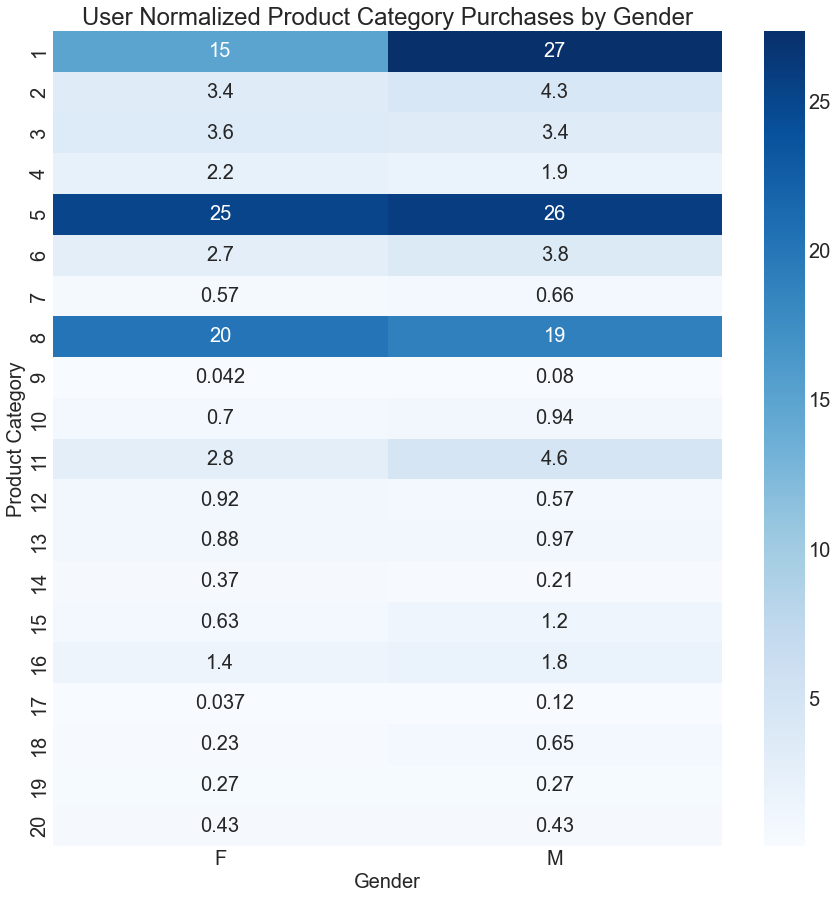

In [264]:
user_normalized_category_gender_counts = category_gender_counts.div(num_users, axis=1)

# Plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(user_normalized_category_gender_counts, annot=True, cbar=True, cmap="Blues")

# Add labels and title
plt.title("User Normalized Product Category Purchases by Gender")
plt.xlabel("Gender")
plt.ylabel("Product Category")
plt.show()

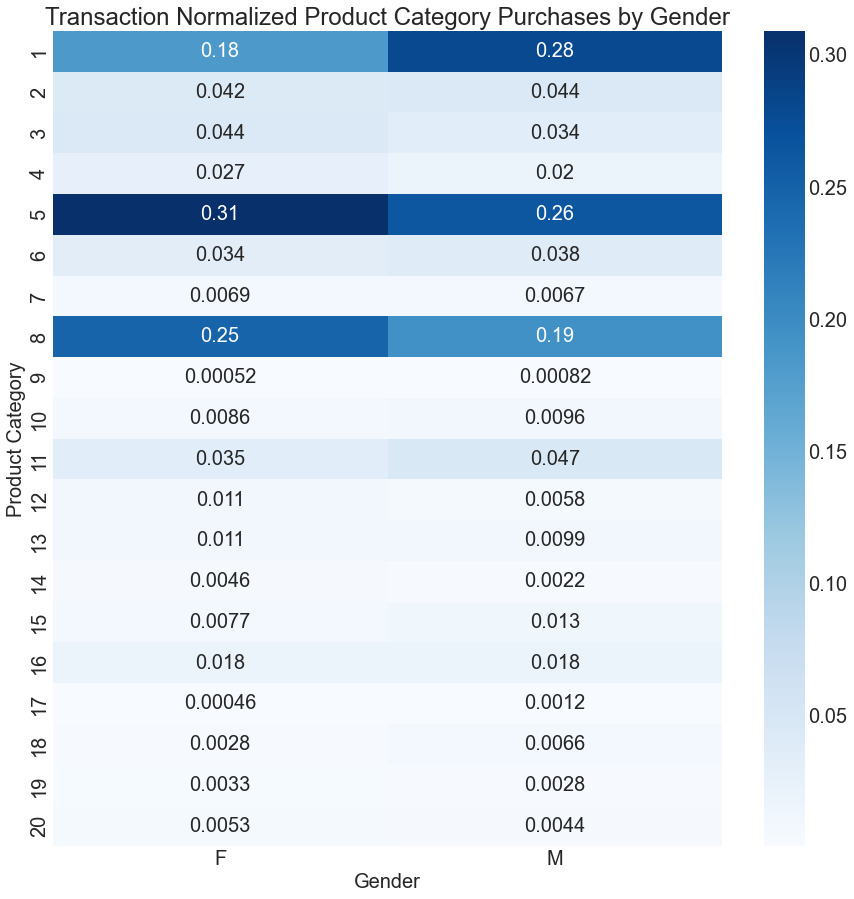

In [265]:
category_gender_counts = df.groupby(['product_category', 'gender'])['purchase'].count().unstack().fillna(0)

num_transactions = df.groupby(['gender'])['purchase'].count()

num_users = df.groupby(['gender'])['user_id'].nunique()

transaction_normalized_category_gender_counts = category_gender_counts.div(num_transactions, axis=1)

# Plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(transaction_normalized_category_gender_counts, annot=True, cbar=True, cmap="Blues")

# Add labels and title
plt.title("Transaction Normalized Product Category Purchases by Gender")
plt.xlabel("Gender")
plt.ylabel("Product Category")
plt.show()

In [266]:
transaction_normalized_category_gender_counts.sum()

gender
F    1.0
M    1.0
dtype: float64

Product categories 1, 5, and 8 are definitely standouts

It looks like men have more purchases in category 1 and women in 5 and 8

We can also look at bar graphs of how much was spent in each category:

## Product Category

### Raw Data

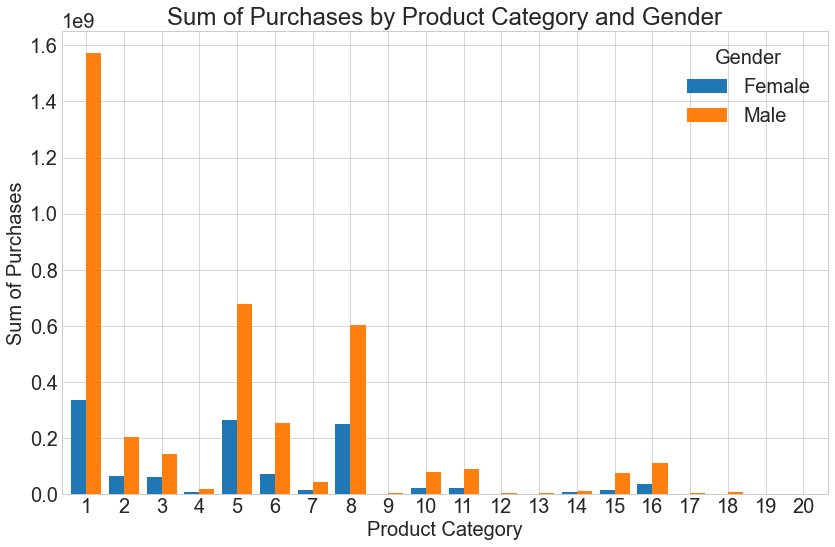

In [208]:
# Group by gender and product_id to count the number of purchases
purchase_amounts = df.groupby(['gender', 'product_category'])['purchase'].sum().unstack().fillna(0)

# Plotting a grouped bar chart
purchase_amounts.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

# Adding labels and title
plt.title("Sum of Purchases by Product Category and Gender")
plt.xlabel("Product Category")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

# Show the plot
plt.show()

### Normalized by Transaction

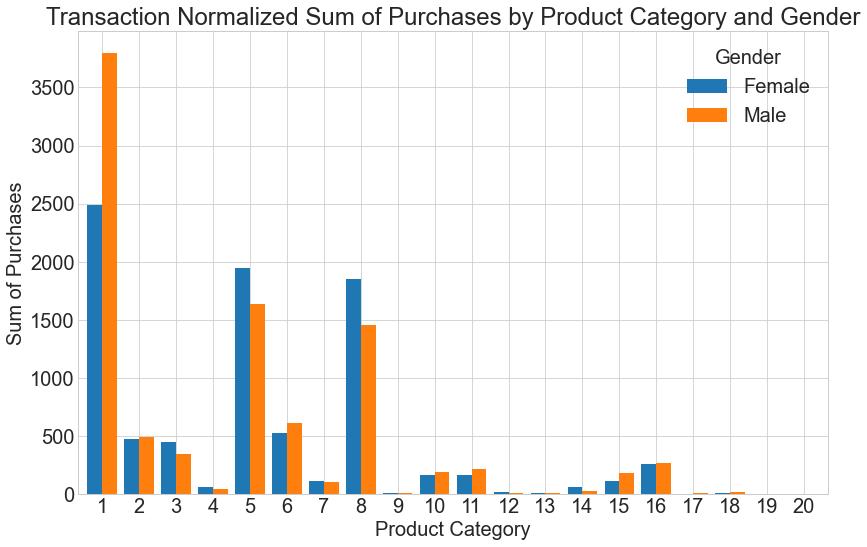

In [209]:
# Normalized

# Group by gender and product_id to count the number of purchases
purchase_amounts = df.groupby(['gender', 'product_category'])['purchase'].sum().unstack().fillna(0)
# Normalize
purchase_amounts_normalized = purchase_amounts.div(num_transactions, axis=0)

# Plotting a grouped bar chart
purchase_amounts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

# Adding labels and title
plt.title("Transaction Normalized Sum of Purchases by Product Category and Gender")
plt.xlabel("Product Category")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

# Show the plot
plt.show()

### Normalized by User

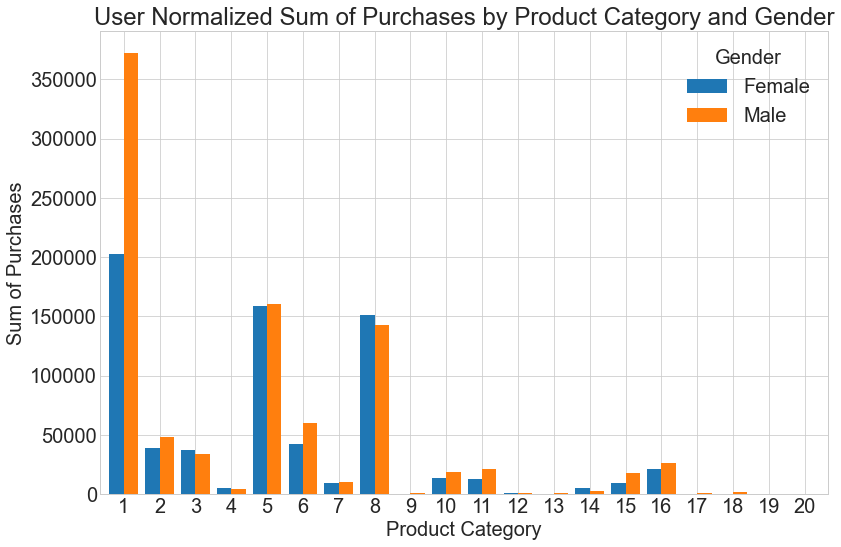

In [210]:
# Normalized

# Group by gender and product_id to count the number of purchases
purchase_amounts = df.groupby(['gender', 'product_category'])['purchase'].sum().unstack().fillna(0)
# Normalize
purchase_amounts_normalized = purchase_amounts.div(num_users, axis=0)

# Plotting a grouped bar chart
purchase_amounts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

# Adding labels and title
plt.title("User Normalized Sum of Purchases by Product Category and Gender")
plt.xlabel("Product Category")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

# Show the plot
plt.show()

Double check that all the axes are aligning properly

In [211]:
print(num_transactions)

gender
F    135809
M    414259
Name: purchase, dtype: int64


In [212]:
print(purchase_amounts)

product_category          1          2          3         4          5   \
gender                                                                    
F                  337631145   64543617   61637516   8933206  264658078   
M                 1572382609  203972569  142447197  18447282  677177151   

product_category         6         7          8        9         10        11  \
gender                                                                          
F                  71104116  15460347  251682476  1100702  22882193  22161326   
M                 253046186  45436384  602636323  5269622  77955108  91629789   

product_category       12       13        14        15         16       17  \
gender                                                                       
F                 2179897  1072884   8564607  15371312   35264942   610477   
M                 3151947  2935717  11450089  77597730  109855670  5268222   

product_category       18     19      20  
gender            

In [213]:
print(purchase_amounts.index)

Index(['F', 'M'], dtype='object', name='gender')


In [214]:
print(num_transactions.index)

Index(['F', 'M'], dtype='object', name='gender')


In [215]:
print(purchase_amounts_normalized.columns)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64', name='product_category')


In [216]:
print(purchase_amounts_normalized.index)

Index(['F', 'M'], dtype='object', name='gender')


## City Category

### Raw data

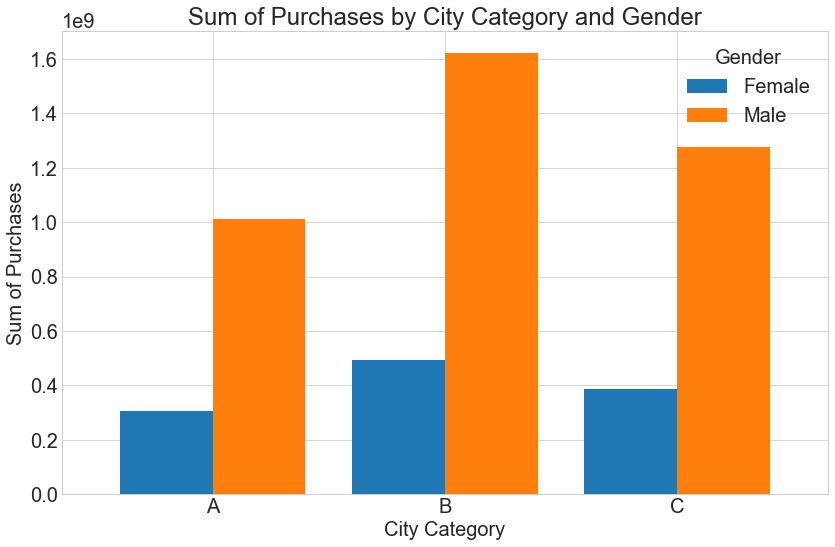

In [217]:
purchase_amounts = df.groupby(['gender', 'city_category'])['purchase'].sum().unstack().fillna(0)

purchase_amounts.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

plt.title("Sum of Purchases by City Category and Gender")
plt.xlabel("City Category")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

plt.show()

### Normalized by Transaction

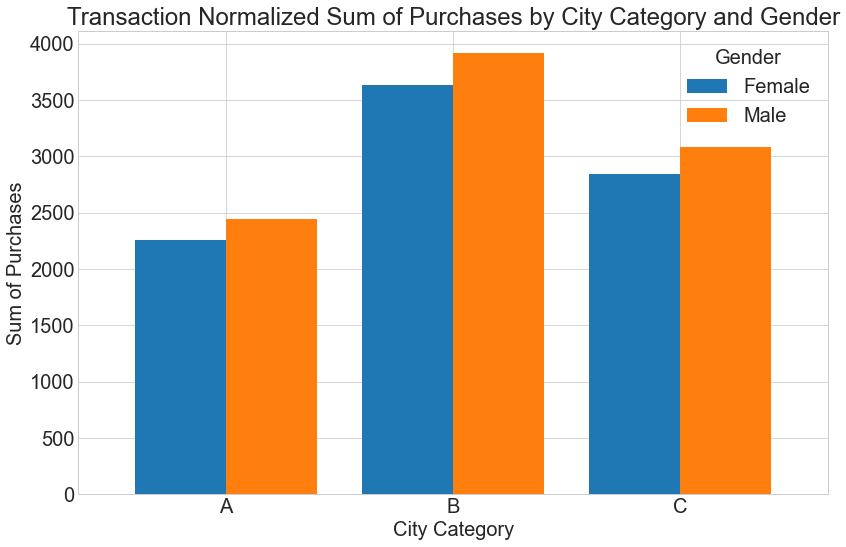

In [218]:
purchase_amounts = df.groupby(['gender', 'city_category'])['purchase'].sum().unstack().fillna(0)

purchase_amounts_normalized = purchase_amounts.div(num_transactions, axis=0)

purchase_amounts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

plt.title("Transaction Normalized Sum of Purchases by City Category and Gender")
plt.xlabel("City Category")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

plt.show()

### Normalized by User

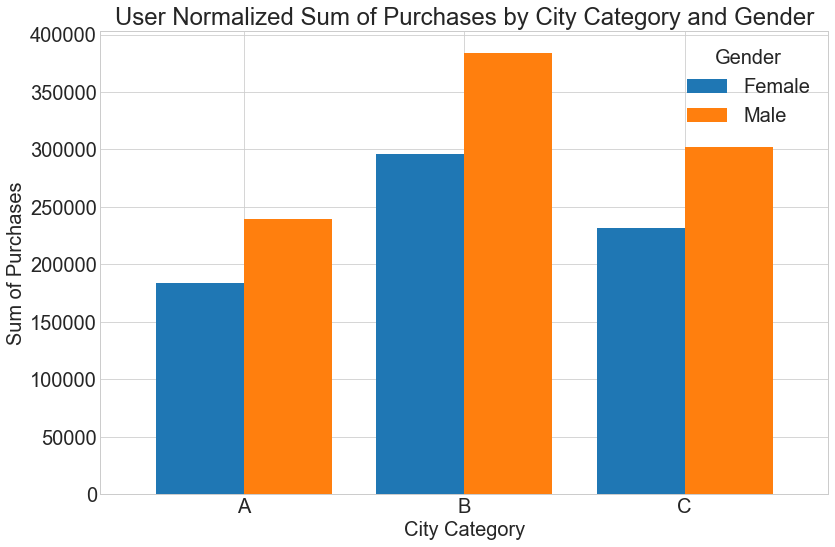

In [219]:
purchase_amounts = df.groupby(['gender', 'city_category'])['purchase'].sum().unstack().fillna(0)

purchase_amounts_normalized = purchase_amounts.div(num_users, axis=0)

purchase_amounts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

plt.title("User Normalized Sum of Purchases by City Category and Gender")
plt.xlabel("City Category")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

plt.show()

## Age

### Raw data

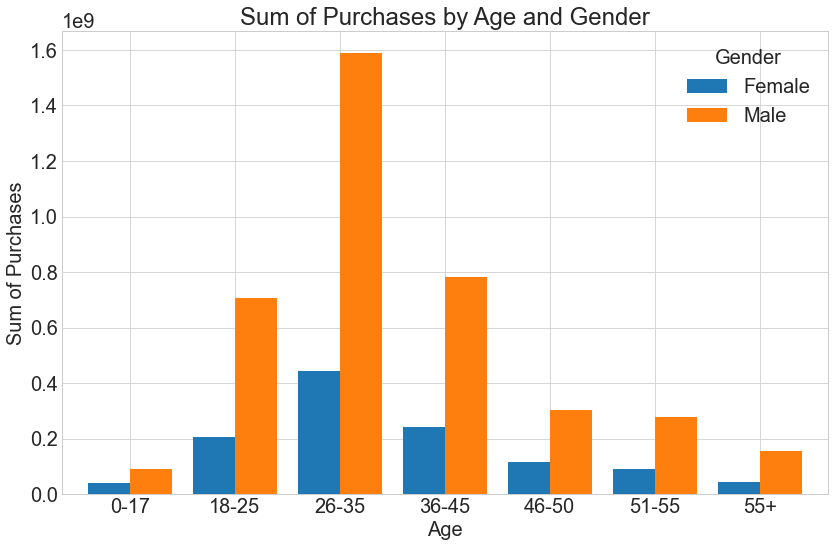

In [220]:
purchase_amounts = df.groupby(['gender', 'age'])['purchase'].sum().unstack().fillna(0)

purchase_amounts.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

plt.title("Sum of Purchases by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

plt.show()

### Normalized by Transaction

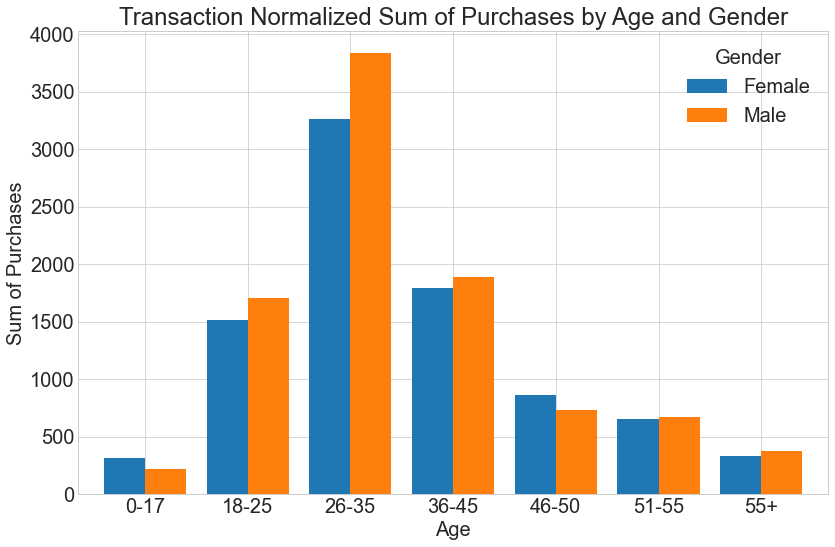

In [221]:
purchase_amounts = df.groupby(['gender', 'age'])['purchase'].sum().unstack().fillna(0)

purchase_amounts_normalized = purchase_amounts.div(num_transactions, axis=0)

purchase_amounts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

plt.title("Transaction Normalized Sum of Purchases by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

plt.show()

### Normalized by User

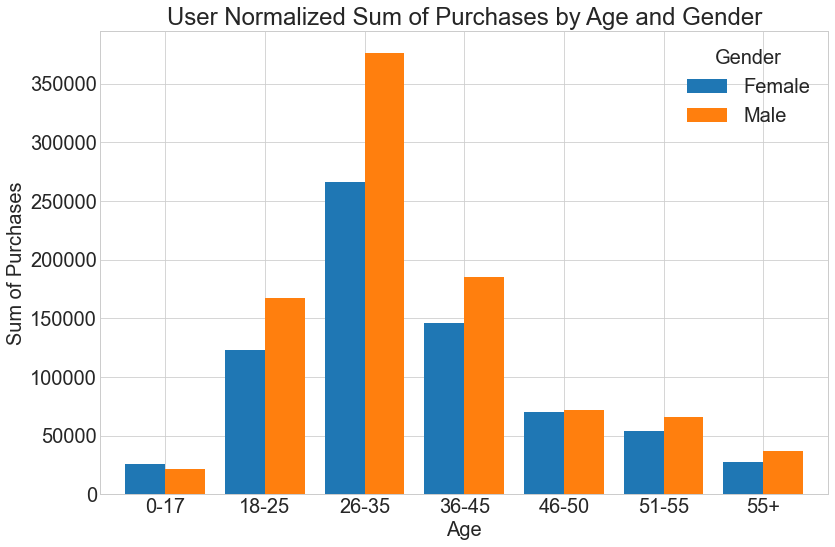

In [222]:
purchase_amounts = df.groupby(['gender', 'age'])['purchase'].sum().unstack().fillna(0)

purchase_amounts_normalized = purchase_amounts.div(num_users, axis=0)

purchase_amounts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=0.5)

plt.title("User Normalized Sum of Purchases by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

plt.show()

# Linear Regression Example

In [223]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

lr_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

lr_df['target'] = diabetes.target

lr_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [224]:
# Split the data into X and y
X = lr_df.drop('target', axis=1)
y = lr_df['target']
X.shape, y.shape

((442, 10), (442,))

In [225]:
from sklearn.model_selection import train_test_split

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape: ", X_train.shape, y_train.shape)
print("Testing set shape: ", X_test.shape, y_test.shape)

Training set shape:  (353, 10) (353,)
Testing set shape:  (89, 10) (89,)


In [226]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
lr = LinearRegression()

In [227]:
# Train the model on the training set, this is how the model learns
lr.fit(X_train, y_train)

LinearRegression()

In [228]:
# Predict on the testing set
# y_preds are predicted values of the target variable based on the features
# Once we have those preds, we can compare them to the actual values of the target variable
# We do that to evaluate the performance of the model
y_pred = lr.predict(X_test)
y_pred.shape

(89,)

In [229]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Evaluate performance of the model

# Variance of the dependent variable (target) explained by the independent variables (features)
# How well the model fits the data, higher is better
r2 = r2_score(y_test, y_pred)

# Average squared distance between the predicted and actual values, lower is better
mse = mean_squared_error(y_test, y_pred)

# Average absolute distance between the predicted and actual values, lower is better
mae = mean_absolute_error(y_test, y_pred)

# Starting point of the regression line on the y axis
# Value of the dependent variable (target) when the independent variables (features) are 0
# If positive, target increases as features increase, if negative, opposite
intercept = lr.intercept_

print("R2 score: ", r2)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("Intercept: ", intercept)

R2 score:  0.4526066021617381
Mean Squared Error:  2900.1732878832313
Mean Absolute Error:  42.79389304196525
Intercept:  151.3456553477407


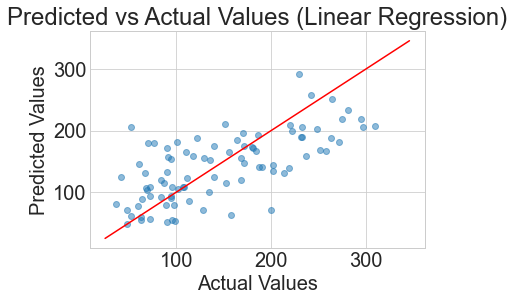

In [230]:
import matplotlib.pyplot as plt

# Plot the predicted vs actual variables
# Predicted values of the target variable are plotted on the x axis
# Actual values of the target variable are plotted on the y axis
# If the model is a good fit, the points should be close to the diagonal line, 
# indicating a strong linear relationship between the actual and predicted values

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (Linear Regression)")
plt.show()

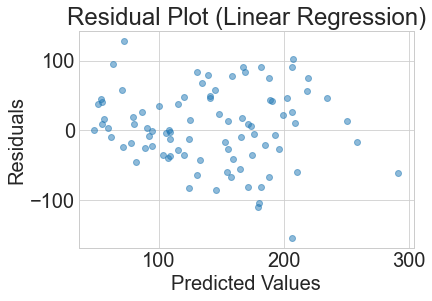

In [231]:
# Plot the residuals
# The residuals are plotted against the predicted values of the target variable
# If the linear regression model is a good fit for the data,
# the residual plot should show a random scatter of the points around zero
# with no discernable trend
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Linear Regression)")
plt.show()

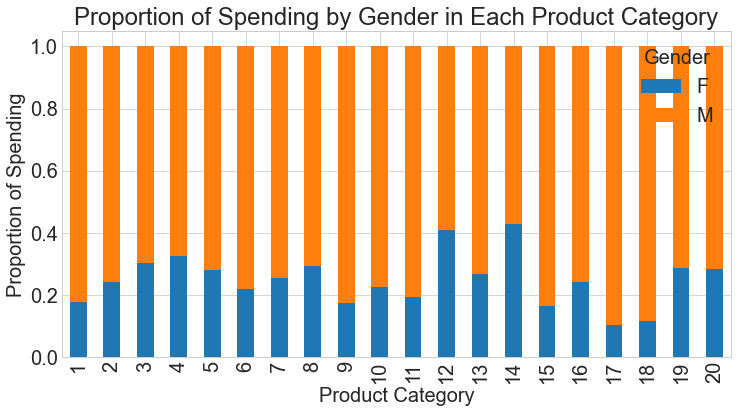

In [232]:
df_grouped = df.groupby(['product_category', 'gender'])['purchase'].sum().unstack()

# Normalize spending within each product category
df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)

# Plot the normalized spending
df_normalized.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title("Proportion of Spending by Gender in Each Product Category")
plt.xlabel("Product Category")
plt.ylabel("Proportion of Spending")
plt.xticks(rotation=90)
plt.legend(title="Gender")
plt.show()


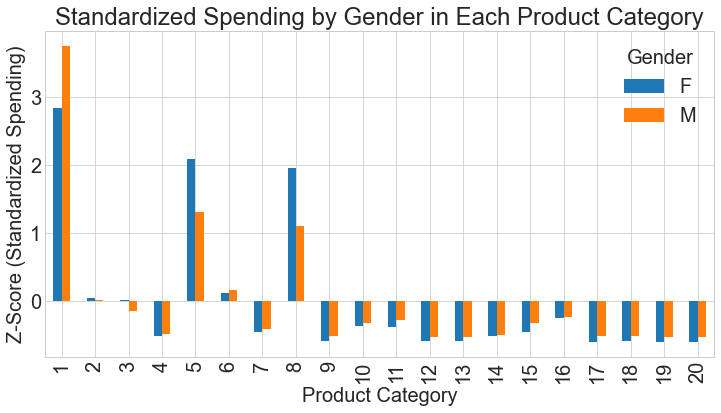

In [233]:
from scipy.stats import zscore

df_zscore = df.groupby(['product_category', 'gender'])['purchase'].sum().unstack().apply(zscore)

df_zscore.plot(kind='bar', figsize=(12, 6))
plt.title("Standardized Spending by Gender in Each Product Category")
plt.xlabel("Product Category")
plt.ylabel("Z-Score (Standardized Spending)")
plt.xticks(rotation=90)
plt.legend(title="Gender")
plt.show()

In [234]:
import statsmodels.api as sm
import pandas as pd

df['gender_numeric'] = df['gender'].map({'M': 1, 'F': 0})  # Convert gender to numeric
X = pd.get_dummies(df['product_category'], drop_first=True)  # One-hot encode categories
X['gender'] = df['gender_numeric']  # Add gender variable
y = df['purchase']

X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               purchase   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                 4.817e+04
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:58:30   Log-Likelihood:            -5.1897e+06
No. Observations:              550068   AIC:                         1.038e+07
Df Residuals:                  550047   BIC:                         1.038e+07
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.364e+04     11.268   1210.386      0.0